# Import Libraries

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### Titanic Passenger data set
We'll be working with the Titanic passenger dataset to build a classification model to predict whether a passenger survied the sinking of the Titanic.  
Here is the data dictionary:

| Variable   |	Definition   |
 |:------|:--------------------------------|
 |survived | survived? 0 = No, 1 = yes  |
 |pclass | Ticket class (int)  |
 |sex	 |sex |
 |age	 | age in years  |
 |sibsp  |	# of siblings / spouses aboard the Titanic |
 |parch  |	# of parents / children aboard the Titanic |
 |fare   |	Passenger fare   |
 |embarked | Port of Embarkation |
 |class  |Ticket class (obj)   |
 |who    | man, woman, or child  |
 |adult_male | True/False |
 |alive  | yes/no  |
 |alone  | yes/no  |

# Data Loading

In [50]:
titanic = sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [51]:
titanic.count()

,0
survived,891
pclass,891
sex,891
age,714
sibsp,891
parch,891
fare,891
embarked,889
class,891
who,891


# Data Preprocessing

In [52]:
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'class', 'who', 'adult_male', 'alone']
target = 'survived'

X = titanic[features]
y = titanic[target]

In [34]:
y.value_counts()

,count
survived,
0,549
1,342


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [54]:
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()

In [55]:
#Define Spearate Preprocessing pipelines for both features type

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # filling missing numeric values with column meduab
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # filling missing categories with the most common label
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [56]:
#combine transformers into one single column transformer

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
], sparse_threshold=0)

# Create a model pipeline

In [64]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor.set_output(transform="default")),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [58]:
# Use a cross validation to optimize the model
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

In [66]:
set_config(transform_output="default")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Added random_state for reproducibility

model = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=2)
model.fit(X_train, y_train)

print("Best parameters found: ", model.best_params_)
print("Best cross-validation accuracy: ", model.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.2s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.2s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__max_depth=None, classifier__min_samples_split=2, classifier__n_estimators=100; total time=

In [67]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.86      0.84       110
           1       0.76      0.68      0.72        69

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.79      0.79      0.79       179



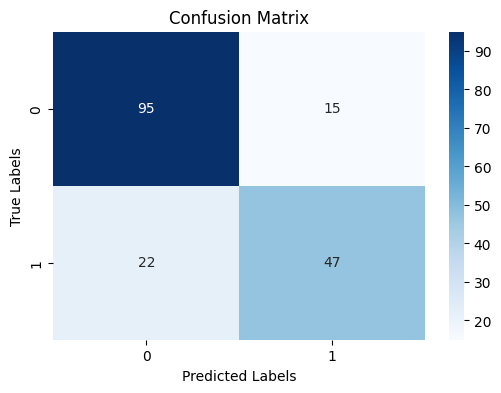

In [68]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()

# Feature Importance

In [69]:
model.best_estimator_['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

array(['sex_female', 'sex_male', 'class_First', 'class_Second',
       'class_Third', 'who_child', 'who_man', 'who_woman',
       'adult_male_False', 'adult_male_True', 'alone_False', 'alone_True'],
      dtype=object)

In [72]:
feature_importances = model.best_estimator_['classifier'].feature_importances_

feature_names = numerical_features + list(model.best_estimator_['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))

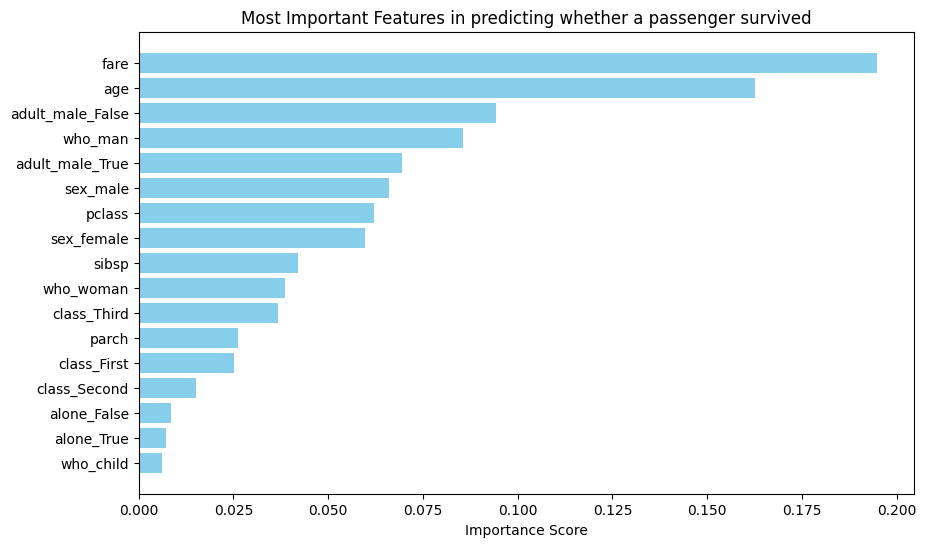


Test set accuracy: 79.33%


In [73]:
importance_df = pd.DataFrame({'Feature': feature_names,
                              'Importance': feature_importances
                             }).sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Most Important Features in predicting whether a passenger survived')
plt.xlabel('Importance Score')
plt.show()

test_score = model.score(X_test, y_test)
print(f"\nTest set accuracy: {test_score:.2%}")

# Try with another model

In [74]:
pipeline.set_params(classifier=LogisticRegression(random_state=42))

model.estimator = pipeline

param_grid = {
    'classifier__solver' : ['liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight' : [None, 'balanced']
}

model.param_grid = param_grid


model.fit(X_train, y_train)


y_pred = model.predict(X_test)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=None, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__class_weight=No

In [75]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87       110
           1       0.81      0.74      0.77        69

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



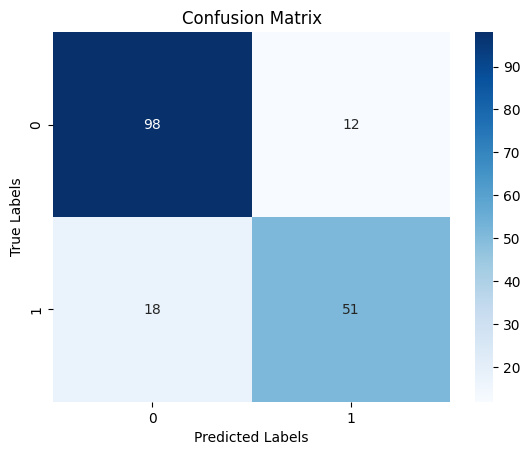

In [76]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()

In [79]:
coefficients = model.best_estimator_.named_steps['classifier'].coef_[0]

# Combine numerical and categorical feature names
numerical_feature_names = numerical_features
categorical_feature_names = (model.best_estimator_.named_steps['preprocessor']
                                     .named_transformers_['cat']
                                     .named_steps['onehot']
                                     .get_feature_names_out(categorical_features)
                            )
feature_names = numerical_feature_names + list(categorical_feature_names)

# Corrected variable name from mportance_df to importance_df
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False, key=abs)  # Sort by absolute values

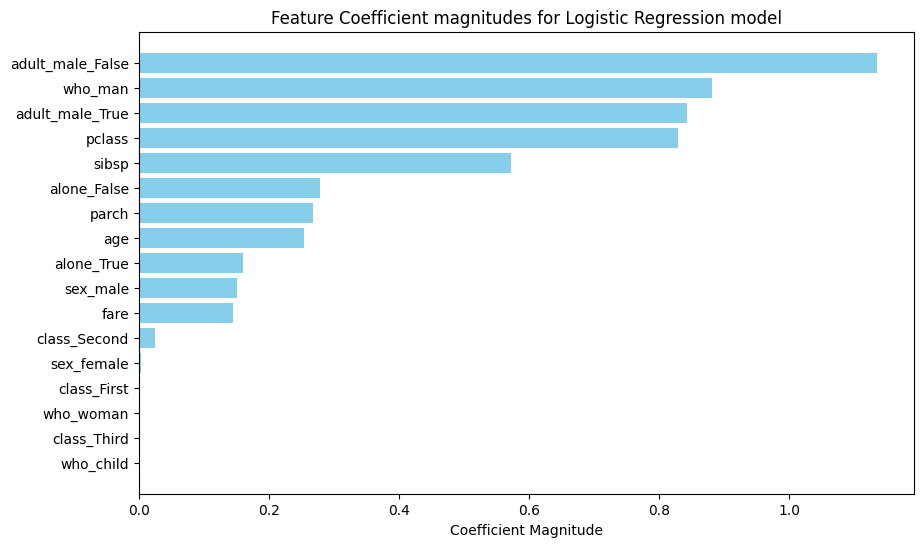


Test set accuracy: 83.24%


In [80]:
# Corrected variable name from mportance_df to importance_df
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False, key=abs)  # Sort by absolute values

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Coefficient'].abs(), color='skyblue')
plt.gca().invert_yaxis()
plt.title('Feature Coefficient magnitudes for Logistic Regression model')
plt.xlabel('Coefficient Magnitude')
plt.show()

# Print test score
test_score = model.best_estimator_.score(X_test, y_test)
print(f"\nTest set accuracy: {test_score:.2%}")

Although the performances of the two models are virtually identical, the features that are important to the two models are very different. This suggests there must be more work to do to better grasp the actual feature importancdes. A smentioned above, it's crucially important to realize that there is most likely plenty of dependence amongst these variables, and a more detailed modelling approach including correlation analysis is required to draw proper conclusions. For example, there is significant information implied between the variables `who_man`, `who_woman`, and `who_child`, because if a person is neither a man nor a woman, then they must be a child.
